## DEMO - Training eines CNN

Verwendung in der Projektphase 2

Das Notebook zeigt beispielhaft die Durchführung folgender Schritte mit Keras:
- Vorverarbeitungsschritte der Bilder
- Trainieren eines CNNs
- Speichern und Laden
- Anwendung
- Transformation in ein TF-lite-Modell

Die verwendeten Bilder befinden sich in `/gitignore/data/images`.

In [6]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from os import listdir,path
import cv2

In [22]:
# Lesen der Filenamen der Bilder in einem Ordner    
img_path = './bilder_nn/'
img_files = listdir(img_path)
#print(img_files)
len(img_files) , len(set(img_files))

(533, 533)

(480, 640, 3)


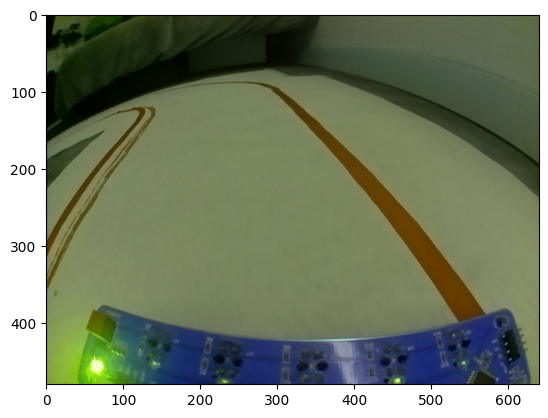

In [23]:
# Ansicht eines Beispielbildes (rot grün vertauscht)
img_example = cv2.imread(img_path + img_files[6])
plt.imshow(img_example)
print(img_example.shape)

In [24]:
# Testweises Einlesen aller Bilder -> Kontrolle der Anzahl
imgs_test = np.array([cv2.imread(img_path+i) for i in img_files])
imgs_test.shape

(533, 480, 640, 3)

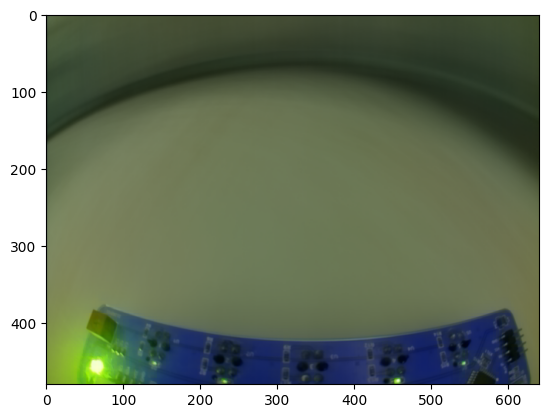

In [25]:
# Mittleres Bilder der Trainingsbilder
img_mean = imgs_test.mean(axis=0).astype('int')
plt.imshow(img_mean)

(300, 640, 3)


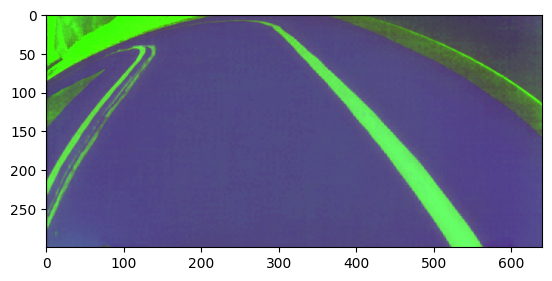

In [26]:
# Testweise Bildbearbeitung

img_example_x = img_example.copy()
img_example_x = img_example_x[80:380, 0:640]
img_example_x = cv2.cvtColor(img_example_x,cv2.COLOR_BGR2HSV)

plt.imshow(img_example_x)
##plt.imshow(cv2.rectangle(img_example_x,sp,ep,(255,255,0),2),cmap='gray')
print(img_example_x.shape)

In [27]:
# Definition einer Funktion zur Vorverarbeitung der Trainingsbilder
def transform_image(img):
    dim = (320,150)
    interpolation = cv2.INTER_AREA
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV) # Verwendung von Graustufenbildern
    img = img[80:380,0:640] # Ausschneiden eines Teilbildes
    img = cv2.resize(img,dim,interpolation) #  Anpassung der Bildgröße
    
    return img

In [15]:
# Alternative für verkleinert Bilder
# Definition einer Funktion zur Vorverarbeitung der Trainingsbilder
def transform_image_small(img):
    dim = (64,48)
    interpolation = cv2.INTER_AREA
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # Verwendung von Graustufenbildern
    img = cv2.resize(img,dim,interpolation) #  Anpassung der Bildgröße
    #img = img[100:200,:] # Ausschneiden eines Teilbildes
    img = img[20:40,:] # Ausschneiden eines Teilbildes
    return img

In [28]:
# Laden und Vorverarbeiten aller Trainingsbilder
imgs = np.array([transform_image(cv2.imread(img_path+i)) for i in img_files])
imgs.shape

(533, 150, 320, 3)

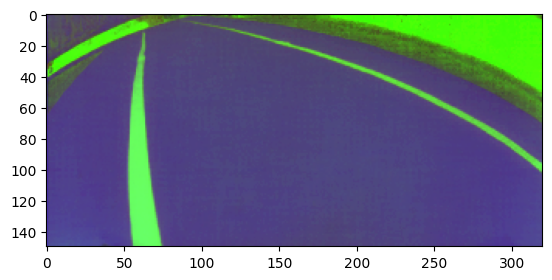

In [29]:
# Ansicht eines vorverarbeiteten Beispielbilder
plt.imshow(imgs[0],cmap='gray')

92.65280093026892
255
0


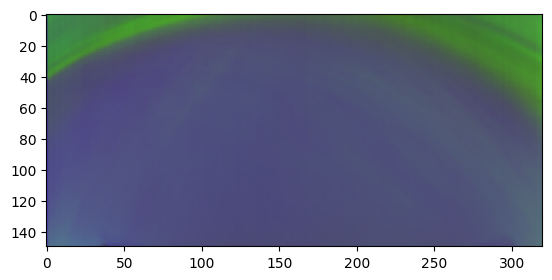

In [30]:
# Mittleres vorverarbeitetes Trainingsbild
plt.imshow(imgs.mean(axis=0).astype('int'),cmap='gray')
print(imgs.mean())
print(imgs.max())
print(imgs.min())

### Spiegeln der Bilder (Augmentation)

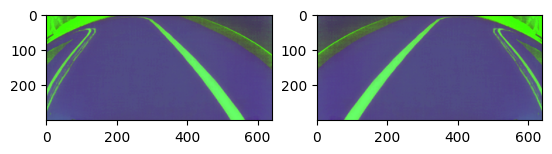

In [31]:
# Test Spiegeln eines Bildes
img_example_x_mirrored = img_example_x[:,::-1] # alternativ mit cv2.flip
plt.figure()
plt.subplot(121)
plt.imshow(img_example_x,cmap='gray')
plt.subplot(122)
plt.imshow(img_example_x_mirrored,cmap='gray')

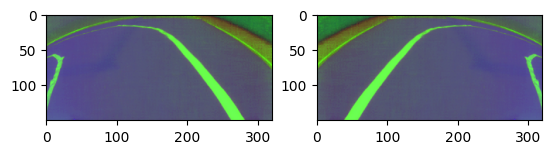

In [32]:
# Test Spiegeln eines vorverarbeiteten Bildes
imgs_mirrored = imgs[:,:,::-1]
plt.figure()
plt.subplot(121)
plt.imshow(imgs[10],cmap='gray')
plt.subplot(122)
plt.imshow(imgs_mirrored[10],cmap='gray')

In [33]:
# Zusammenfügen der ungespiegelten und der gespiegelten Trainingsdaten
print(imgs.shape)
print(imgs_mirrored.shape)
imgs_all = np.concatenate((imgs,imgs_mirrored))
print(imgs_all.shape)

(533, 150, 320, 3)
(533, 150, 320, 3)
(1066, 150, 320, 3)


### "Spiegeln" der Lenkwinkel (Agumentation)
- inklusive des Ladens/Extrahierens der Lenkwinkel aus den Dateinamen

In [36]:
# Position des Lenkwinkels im Filenamen (abhängig vom OS!)
print(img_files[0])
print(img_files[0][31:-4]) # Raspberry/Linux
##print('-',i[50:-4],'-') # Windows


Bild 2023-09-26 14:13:27_Angle_115.png
115


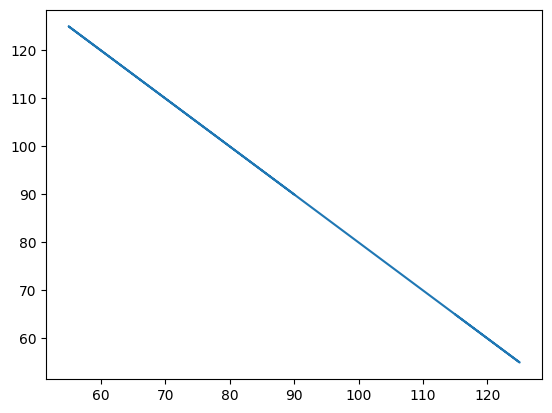

In [35]:
angles = np.array([int(i[31:-4]) for i in img_files]) # Extrahieren der Lenkwinkel aus dem Dateinamen
angles_mirrored = [-(a-90)+90 for a in angles] # Spiegeln der Winkel

# Kontrolle
plt.plot(angles,angles_mirrored)
angles_all = np.hstack((angles,angles_mirrored)) # Zusammenführen der ungespiegelten und gespiegelten Winkel

<AxesSubplot:>

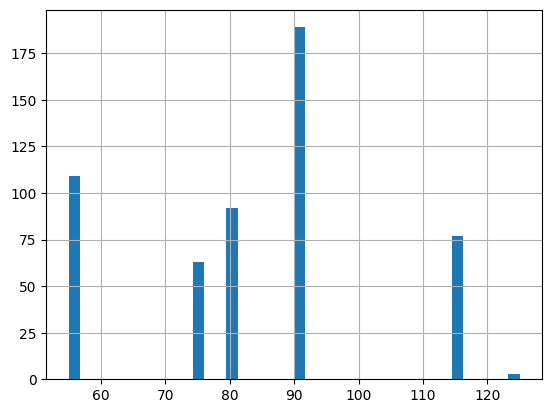

In [37]:
pd.Series(angles, name ='angles').hist(bins = 40)

In [38]:

angles_all

array([115, 125,  75, ...,  90, 125,  90])

### Verteilung der Lenkwinkel

<AxesSubplot:>

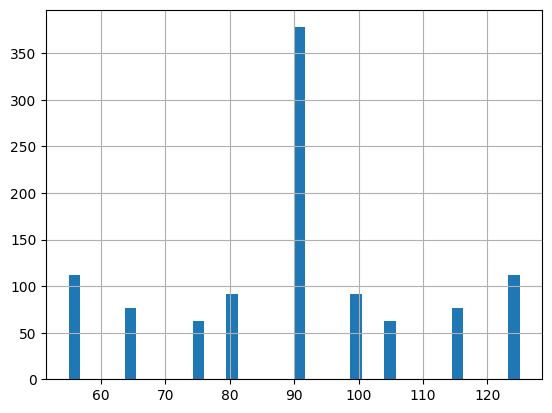

In [39]:
pd.Series(angles_all, name ='angles').hist(bins = 40)

In [40]:
# Kontrolle und Reshapen der Trainingsdaten
print(angles_all.shape)
print(imgs_all.shape)
n,h,w=imgs_all.shape
imgs_all = imgs_all.reshape((n,h,w,1)) # Convolutional Input-Layer benötigt diese Format/Shape
print(imgs_all.shape)

(1066,)
(1066, 150, 320, 3)


ValueError: too many values to unpack (expected 3)

### Einteilen der Trainingsdaten

In [41]:
# Split Trainings- und Testdaten
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(imgs_all, angles_all, test_size = 0.2, random_state = 1)

### Erstellen des NN  mit Tensorflow

In [42]:
# Korntrolle
print(X_train.dtype)
print(X_train.shape)
print(y_train.shape)
print(X_validate.dtype)
print(X_validate.shape)
print(X_validate.shape)

uint8
(852, 150, 320, 3)
(852,)
uint8
(214, 150, 320, 3)
(214, 150, 320, 3)


In [43]:
# Import notwendiger Klassen und Funktionen
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam

In [44]:
# Kontrolle bzw. Ermitteln des Shape der Eingabedaten/Inputshape
n,h,w,f=imgs_all.shape
input_shape = (h,w,f)
print(input_shape)

(150, 320, 3)


In [46]:
# Erstellen des Netzes
# Keras Sequntial API
model = tf.keras.Sequential(name='dnn') 

# Convolution Layers 
# elu: Expenential Linear Unit, similar to leaky Relu 
model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=input_shape, activation='elu')) 
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu')) 
model.add(Dropout(0.2)) # more robustness 
model.add(Conv2D(64, (3, 3), activation='elu')) 

# Fully Connected Layers 
model.add(Flatten()) 
model.add(Dropout(0.2)) # more robustness 
##model.add(Dense(100, activation='elu')) 
model.add(Dense(50, activation='elu')) 
model.add(Dense(10, activation='elu'))

# Output Layer: turning angle
model.add(Dense(1)) 


In [ ]:
# Alternative für kleiens Bild
# Erstellen des Netzes für das stark verkleinert Bild

n,h,w,f=imgs_all.shape
input_shape = (h,w,f)
print(input_shape)
# Keras Sequntial API
model_small = tf.keras.Sequential(name='dnn_small') 

# Convolution Layers 
# elu: Expenential Linear Unit, similar to leaky Relu 
model_small.add(Conv2D(10, (3, 3), strides=(2, 2), input_shape=input_shape, activation='elu')) 
model_small.add(Conv2D(20, (2, 2), strides=(2, 2), activation='elu'))
model_small.add(Conv2D(40, (2, 2), strides=(2, 2), activation='elu'))

# Fully Connected Layers 
model_small.add(Flatten()) 
model_small.add(Dropout(0.2)) # more robustness 
model_small.add(Dense(5, activation='elu')) 
model_small.add(Dense(5, activation='elu')) 

# Output Layer: turning angle
model_small.add(Dense(1)) 

In [47]:
# Kontrolle der Architektur
model.summary()

Model: "dnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 158, 24)       1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 77, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 37, 48)        43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 35, 64)        27712     
_________________________________________________________________
dropout (Dropout)            (None, 14, 35, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 33, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 25344)             0       

### Trainieren des NN

In [48]:
# Kompiliern des Modells und Wahl von Fehlerfunktion und Optimizer
model.compile(loss ='mse', optimizer=Adam(lr=0.001))

In [49]:
# Training
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs= 50,
    verbose=1,
    validation_data=(X_validate,y_validate)
)

2023-09-27 13:32:35.876430: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122688000 exceeds 10% of free system memory.
2023-09-27 13:32:36.589130: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-09-27 13:32:36.603502: W tensorflow/core/platform/profile_utils/cpu_utils.cc:116] Failed to find bogomips or clock in /proc/cpuinfo; cannot determine CPU frequency


Epoch 1/50
27/27 [==============================] - 145s 5s/step - loss: 25076.0811 - val_loss: 437.3451
Epoch 2/50
27/27 [==============================] - 131s 5s/step - loss: 285.9965 - val_loss: 192.7007
Epoch 3/50
27/27 [==============================] - 128s 5s/step - loss: 170.3939 - val_loss: 238.3917
Epoch 4/50
27/27 [==============================] - 154s 6s/step - loss: 196.7174 - val_loss: 142.4345
Epoch 5/50
27/27 [==============================] - 167s 6s/step - loss: 123.7476 - val_loss: 178.2314
Epoch 6/50
27/27 [==============================] - 156s 6s/step - loss: 105.9172 - val_loss: 144.3222
Epoch 7/50
27/27 [==============================] - 151s 6s/step - loss: 105.5650 - val_loss: 124.2474
Epoch 8/50
27/27 [==============================] - 151s 6s/step - loss: 75.6468 - val_loss: 95.2684
Epoch 9/50
27/27 [==============================] - 152s 6s/step - loss: 80.4111 - val_loss: 120.0900
Epoch 10/50
27/27 [==============================] - 152s 6s/step - loss: 

In [50]:
def train_loss_acc_plot(history,skip=0):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'][skip:], label='Loss')
    plt.plot(history.history['val_loss'][skip:], label='Validation Loss')
    plt.legend()
    plt.title('Training - Loss Function')

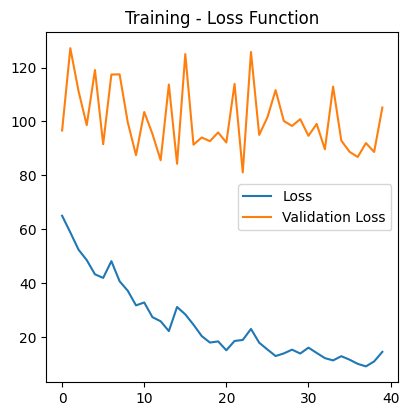

In [51]:
# Begutachtung des Trainingsverlaufs
train_loss_acc_plot(history,skip=10)

In [ ]:
# Eventuelle weiteres Training
history = model.fit(
    X_train,
    y_train,
    batch_size=200,
    epochs= 10,
    verbose=1,
    validation_split=.3
)

In [52]:
# Trainings- und Testfehler
mse_train = model.evaluate(X_train,y_train)
mse_validate = model.evaluate(X_validate,y_validate)

print('MSE train/val: {:.4f} / {:.4f}'.format(mse_train,mse_validate))
print('RMSE train/val: {:.4f} / {:.4f}'.format(np.sqrt(mse_train),np.sqrt(mse_validate)))

2023-09-27 15:37:31.408859: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122688000 exceeds 10% of free system memory.


7/7 [==============================] - 12s 2s/step - loss: 105.1975
MSE train/val: 20.7746 / 105.1975
RMSE train/val: 4.5579 / 10.2566


2023-09-27 15:38:42.674350: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122688000 exceeds 10% of free system memory.


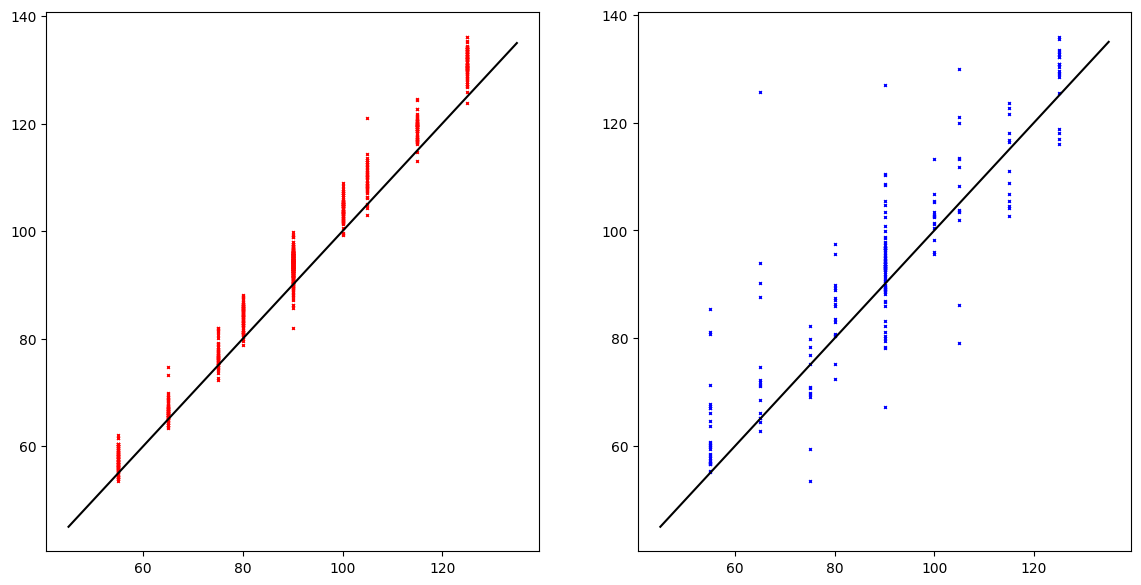

In [53]:
# Visualisierung der Fehler
y_train_p = model.predict(X_train)
y_validate_p = model.predict(X_validate)
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(y_train,y_train_p,'rx',ms=2)
plt.plot([45,135],[45,135],'k-')
plt.subplot(122)
plt.plot(y_validate,y_validate_p,'bx',ms=2)
plt.plot([45,135],[45,135],'k-')

In [54]:
# Speichern des trainierten Modells
#path_to_model_file = './DEMO_MODEL.h5'# Speichert im H5-Format
path_to_model_file = './DEMO_MODEL' # Speichert im SavedModel-Format
model.save(path_to_model_file)

2023-09-27 15:40:34.108896: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./DEMO_MODEL/assets


## Verwendung eines trainierten Modells

In [56]:
# Laden eines Modells
path_to_model_file = './DEMO_MODEL'
model_loaded = tf.keras.models.load_model(path_to_model_file)

In [5]:
# Informationen über das Netz erhalten
#model_loaded.get_config()

In [57]:
# Shape des Input-Layers
model_loaded.layers[0].input_shape

(None, 150, 320, 3)

In [58]:
mse_train = model_loaded.evaluate(X_train,y_train)
mse_validate = model_loaded.evaluate(X_validate,y_validate)

print('MSE train/val: {:.4f} / {:.4f}'.format(mse_train,mse_validate))
print('RMSE train/val: {:.4f} / {:.4f}'.format(np.sqrt(mse_train),np.sqrt(mse_validate)))

2023-09-27 15:42:24.594351: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122688000 exceeds 10% of free system memory.


7/7 [==============================] - 12s 2s/step - loss: 105.1975
MSE train/val: 20.7746 / 105.1975
RMSE train/val: 4.5579 / 10.2566


2023-09-27 15:43:41.041318: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122688000 exceeds 10% of free system memory.


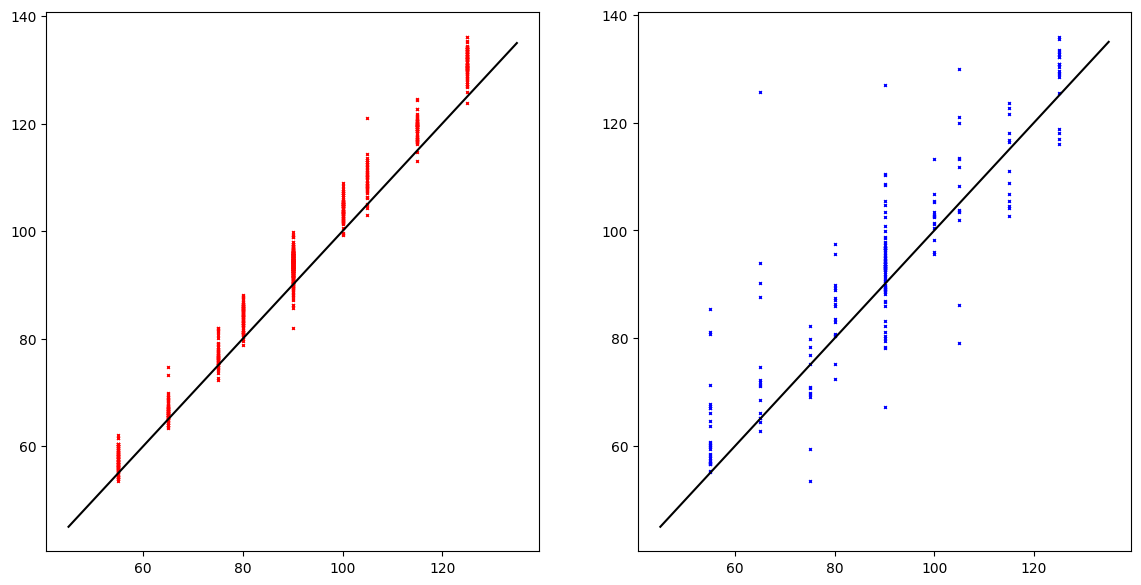

In [59]:
# Visualisierung der Fehler
y_train_p = model_loaded.predict(X_train)
y_validate_p = model_loaded.predict(X_validate)
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(y_train,y_train_p,'rx',ms=2)
plt.plot([45,135],[45,135],'k-')
plt.subplot(122)
plt.plot(y_validate,y_validate_p,'bx',ms=2)
plt.plot([45,135],[45,135],'k-')

### Anwendung des Netzes zur Bestimmung des Lenkwinkels

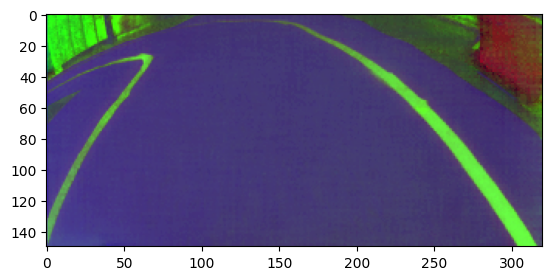

In [65]:
# Wahl eines Beispielbildes!
xe = np.array( [X_train[0]] )
xe.shape
plt.imshow(X_train[0])

In [66]:
# Mittels der Methode predict
model_loaded.predict(xe)

array([[93.764]], dtype=float32)

In [67]:
# Mittels der Methode __call__ 
model_loaded(xe).numpy()

array([[93.764]], dtype=float32)

In [68]:
model_loaded.__call__(xe)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[93.764]], dtype=float32)>

### Ausführungsgeschwindigkeit

In [72]:
# langsam
%timeit model_loaded.predict(xe)

264 ms ± 20.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
# schneller
%timeit model_loaded(xe).numpy()

75.9 ms ± 4.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Model als Tensorflow-lite-Modell speichern

In [3]:
# Speichern des Modells im TF-eigenen Format
# -> erzeugt Ordner mit Daten des Modells
#path_to_model_tf_format = './gitignore/data/model/DEMO_MODELL_saved_on_RPI'
path_to_model_tf_format = './DEMO_MODELL_Lite'
#model.save(path_to_model_tf_format)
#model_loaded.save(path_to_model_tf_format)

In [4]:
path_to_model_tf_format = './DEMO_MODEL'
converter = tf.lite.TFLiteConverter.from_saved_model(path_to_model_tf_format)
#converter = tf.lite.TFLiteConverter.from_keras_model(model_loaded)

NameError: name 'tf' is not defined

In [1]:
tflite_model = converter.convert()
# This step fails on my RPI, but works in WinPython. Rob.

NameError: name 'converter' is not defined

In [ ]:
path_to_model_tf_format = './gitignore/data/model/DEMO_MODEL.tflite'
with open(path_to_model_tf_format, 'wb') as f:
    f.write(tflite_model)

In [ ]:
print(angles[0])
plt.imshow(imgs[0],cmap='gray')

In [ ]:
path = './data/some_images_used_by_nb_Using_Tensorflow_lite/'
for i in [1,10,100]:
    name = f"image_{i}_angle_{str(angles[i])}"
    print(name)
    cv2.imwrite(path+name+'.jpg',imgs[i])